# Home Temperature and Presence Prediction

This kernel is a personal training project. It aim's to predict the temperature in my appartment at a specific time to have the right temperature when I will be back home

In [10]:
import pandas as pd
import numpy as np
import time
import datetime
from matplotlib import pyplot

data_home = pd.read_csv('./export_temperature.csv')
data_home = data_home[(data_home['date'].str.find('00:00:00.000000') == -1) & (data_home['temperature'] != 2147483647) & (data_home['id'] % 10 == 0)]
data_home = data_home.reset_index(drop=True)
a_hours = []
a_prev_temp = []
data_home = data_home.head(2000)
j=0
for value in data_home.values:
    data_home.at[j, 'date'] = data_home.values[j][1].split(' ')[0]
    a_hours.append(value[1].split(' ')[1].split('.')[0])
    
    if j!=0:
        a_prev_temp.append(data_home.values[j-1][2])
    else:
        a_prev_temp.append(data_home.values[j][2])
    j+=1
    
data_home = data_home.assign(hour = pd.Series(a_hours).values)
data_home = data_home.assign(prev_temp = pd.Series(a_prev_temp).values)   


data_lille = pd.read_csv('./export-lille.csv')
i=0
j=0
df_lille = pd.DataFrame({}, columns= data_lille.columns)

for values in data_home.values:
    if len(data_lille['DATE'][ data_lille['DATE'] == values[1]]) > 0 : 
        df_lille = df_lille.append(data_lille.iloc[data_lille['DATE'][data_lille['DATE'] == values[1]].index], ignore_index=True)
        i+=0


In [11]:
from sklearn.preprocessing import LabelEncoder
data = pd.concat([data_home, df_lille], axis=1, sort=False)
data = data.drop(columns=['DATE', 'id'])
data['temperature'][data['temperature'] == 0] = data['temperature'].mean()

/home/sebastien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


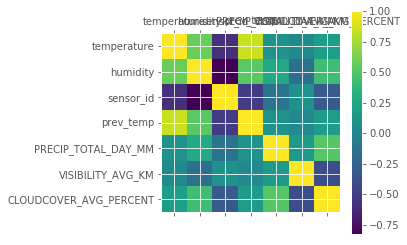

In [12]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

data_corelation = data.copy()
corr_matrix = data_corelation.corr()
plt.matshow(corr_matrix)
plt.xticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.colorbar()
plt.show()

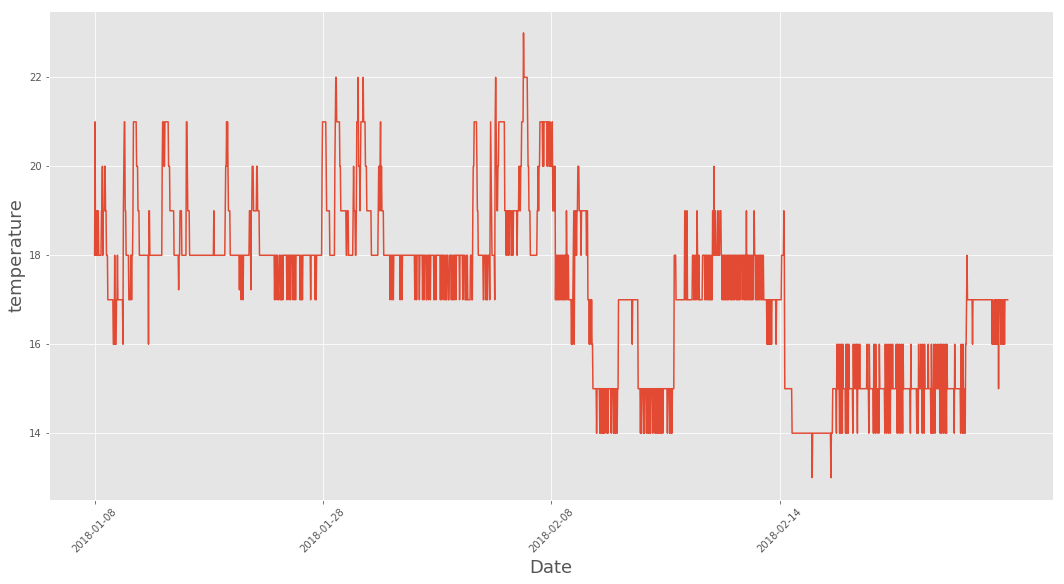

In [13]:
plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]), data['temperature'])
plt.xticks(range(0,data.shape[0],500),data['date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('temperature',fontsize=18)
plt.show()

In [14]:
data['hour'] = data['hour'].apply(lambda x: int(x.split(':')[0])*3600+int(x.split(':')[1])*60+int(x.split(':')[2]))
data['date'] = data['date'].apply(lambda x: time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d").timetuple()) - time.mktime(datetime.datetime.strptime(x.split('-')[0], "%Y").timetuple()))
data = pd.get_dummies(columns=['OPINION'], data=data)

In [15]:
from sklearn.preprocessing import MinMaxScaler

X = data[data.columns.drop('temperature')]
scaler_x = MinMaxScaler()
X_scale = scaler_x.fit_transform(X)

y = data['temperature']



/home/sebastien/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Create training dataset
train_X, test_X, train_y, test_y = train_test_split(X_scale, y, random_state = 1)

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

xgb_model = XGBRegressor(base_score=0.9, booster='gbtree', learning_rate=0.2, max_depth = 7)
xgb_model.fit(train_X, train_y, verbose=False)
val_pred = xgb_model.predict(test_X)
xgb_score = xgb_model.score(test_X, test_y)

print(mean_squared_error(val_pred, test_y))
print(xgb_score)

0.2455657840786862
0.9256635260744612


Index(['date', 'humidity', 'sensor_id', 'hour', 'prev_temp',
       'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
       'TEMPERATURE_MORNING_C', 'TEMPERATURE_NOON_C', 'TEMPERATURE_EVENING_C',
       'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
       'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C',
       'DEWPOINT_MAX_C', 'WINDTEMP_MAX_C', 'WEATHER_CODE_MORNING',
       'WEATHER_CODE_NOON', 'WEATHER_CODE_EVENING',
       'OPINION_météo défavorable', 'OPINION_météo très défavorable'],
      dtype='object')
[0.13095488 0.20041972 0.00335782 0.3937041  0.09233998 0.0161595
 0.01028332 0.0270724  0.00293809 0.00356768 0.00524659 0.0115425
 0.0224554  0.01322141 0.02203568 0.01532004 0.00083945 0.00314795
 0.00293809 0.00986359 0.00398741 0.00860441 0.         0.        ]


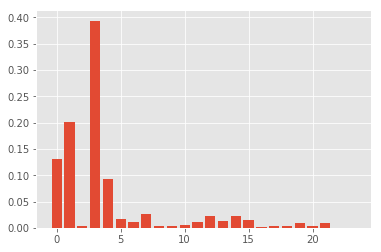

In [17]:
print(X.columns)


pyplot.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
pyplot.show()